In [2]:
# Импортируем pandas
import pandas as pd

# Указываем путь к файлу в Colab
file_path = '/content/test case data analyst.xlsx'

# Загружаем данные
data = pd.read_excel(file_path)

# Выводим первые строки для проверки
print(data.head())

                                product_id  quantity  is_trial_period  \
0  1week_4.99_USD_subscription_7days_trial         1            False   
1  1week_4.99_USD_subscription_7days_trial         1            False   
2  1week_4.99_USD_subscription_7days_trial         1            False   
3  1week_4.99_USD_subscription_7days_trial         1            False   
4  1week_4.99_USD_subscription_7days_trial         1            False   

  purchase_date  user_id  
0    2020-02-19  9484222  
1    2020-02-17  9422402  
2    2020-02-18  4997991  
3    2020-02-18  9455582  
4    2020-02-16  8803657  


In [20]:
# Преобразуем purchase_date в datetime

data['purchase_date'] = pd.to_datetime(data['purchase_date'])

# Убедимся, что данные отсортированы по дате
data = data.sort_values(by='purchase_date')

# Выведем первые строки для проверки
print(data.head())

                                  product_id  quantity  is_trial_period  \
0    1week_4.99_USD_subscription_7days_trial         1             True   
597  1week_4.99_USD_subscription_7days_trial         1             True   
598  1week_4.99_USD_subscription_7days_trial         1             True   
599  1week_4.99_USD_subscription_7days_trial         1             True   
600  1week_4.99_USD_subscription_7days_trial         1             True   

    purchase_date  user_id                 cohort  cohort_index  \
0      2020-01-01  8190554  2019-12-30/2020-01-05             0   
597    2020-01-01  8202186  2019-12-30/2020-01-05             0   
598    2020-01-01  8206462  2019-12-30/2020-01-05             0   
599    2020-01-01  8207233  2019-12-30/2020-01-05             0   
600    2020-01-01  8218996  2019-12-30/2020-01-05             0   

    first_purchase_date  weeks_since_first_purchase  
0            2020-01-01                           0  
597          2020-01-01               

In [21]:
# Создание когорт
data['cohort'] = data.groupby('user_id')['purchase_date'].transform('min').dt.to_period('W')
data['cohort_index'] = (data['purchase_date'].dt.to_period('W') - data['cohort']).apply(lambda x: x.n)

# Расчет LTV
cohorts = data.groupby(['cohort', 'cohort_index']).agg({'user_id': 'nunique', 'quantity': 'sum'}).reset_index()
cohorts['ltv'] = cohorts['quantity'] * 4.99 / cohorts['user_id']  # 4.99 USD - стоимость подписки

# Текущий LTV (кумулятивный)
current_ltv = cohorts.groupby('cohort_index')['ltv'].sum().cumsum()

# Выведем текущий LTV
print(current_ltv)

cohort_index
0     39.966378
1     74.939583
2    104.902973
3    129.855764
4    149.821431
5    164.803635
6    174.783635
7    179.773635
Name: ltv, dtype: float64


In [22]:
# Рассчитаем средний LTV
average_ltv = data.groupby('user_id')['quantity'].sum().mean() * 4.99  # 4.99 USD — стоимость подписки
print("Средний LTV:", average_ltv)

# Прогнозируемый LTV на 26 недель
predicted_ltv = [average_ltv] * 26

Средний LTV: 9.058449506429923


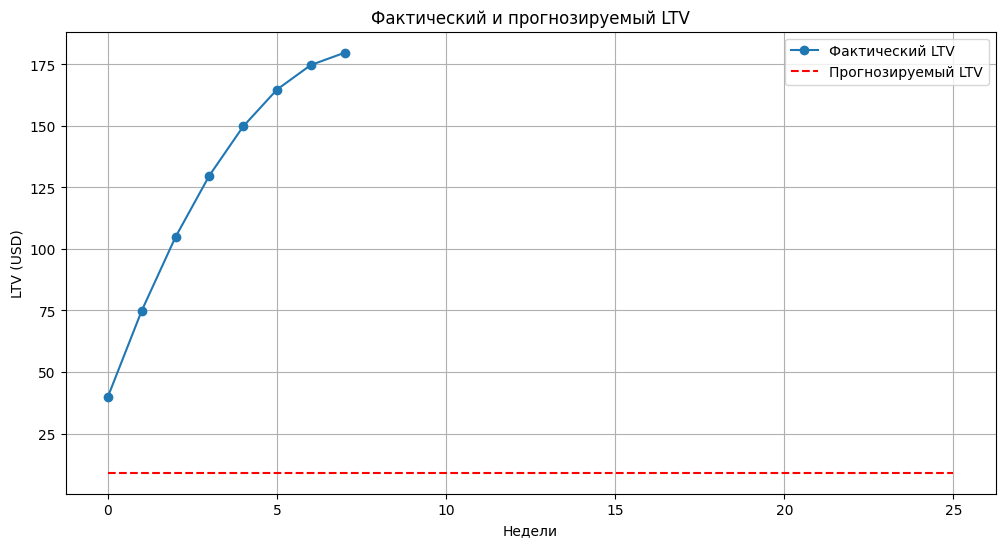

In [23]:
# Построим график
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(current_ltv.index, current_ltv.values, label='Фактический LTV', marker='o')
plt.plot(range(26), predicted_ltv, label='Прогнозируемый LTV', linestyle='--', color='red')
plt.title('Фактический и прогнозируемый LTV')
plt.xlabel('Недели')
plt.ylabel('LTV (USD)')
plt.legend()
plt.grid(True)
plt.show()

In [24]:
# Задаем стоимость привлечения пользователя (CPA)
cpa = 6  # USD

# ROMI на 4 недели
romi_4_weeks = (current_ltv[3] - cpa) / cpa

# ROMI на полгода (26 недель)
romi_half_year = (predicted_ltv[-1] - cpa) / cpa

# Выведем результаты
print(f"ROMI на 4 недели: {romi_4_weeks:.2f}")
print(f"ROMI на полгода: {romi_half_year:.2f}")

ROMI на 4 недели: 20.64
ROMI на полгода: 0.51


Как проверить, сколько покупок совершают пользователи?

In [25]:
user_purchase_counts = data.groupby('user_id')['purchase_date'].count()
print(user_purchase_counts.describe())

count    62909.000000
mean         1.815321
std          1.536030
min          1.000000
25%          1.000000
50%          1.000000
75%          2.000000
max         10.000000
Name: purchase_date, dtype: float64


Проверим диапазон дат в данных.

In [26]:
# Проверяем минимальную и максимальную дату
min_date = data['purchase_date'].min()
max_date = data['purchase_date'].max()

print("Минимальная дата:", min_date)
print("Максимальная дата:", max_date)

Минимальная дата: 2020-01-01 00:00:00
Максимальная дата: 2020-02-20 00:00:00


In [28]:
print(data.columns)

Index(['product_id', 'quantity', 'is_trial_period', 'purchase_date', 'user_id',
       'cohort', 'cohort_index', 'first_purchase_date_x',
       'weeks_since_first_purchase', 'first_purchase_date_y'],
      dtype='object')


In [32]:
# Преобразуем purchase_date в datetime, если это еще не сделано
data['purchase_date'] = pd.to_datetime(data['purchase_date'])

# Находим первую покупку каждого пользователя
first_purchase = data.groupby('user_id')['purchase_date'].min().reset_index()
first_purchase.columns = ['user_id', 'first_purchase_date']

# Добавляем первую покупку в основной DataFrame
data = data.merge(first_purchase, on='user_id')

# Используем правильное имя столбца (first_purchase_date_y)
data['weeks_since_first_purchase'] = (data['purchase_date'] - data['first_purchase_date_y']).dt.days // 7

# Проверяем, есть ли данные за 24 недели
has_24_weeks_data = (data['weeks_since_first_purchase'] >= 24).any()

if has_24_weeks_data:
    print("В данных есть информация за 24 недели.")
else:
    print("В данных нет информации за 24 недели.")

В данных нет информации за 24 недели.


Если пользователи перестают оплачивать подписки после 7 недель, то LTV за 24 недели будет равен LTV за 7 недель.

Если пользователи продолжают оплачивать подписки, можно использовать средний LTV для экстраполяции.

In [33]:
print(data.columns)

Index(['product_id', 'quantity', 'is_trial_period', 'purchase_date', 'user_id',
       'cohort', 'cohort_index', 'first_purchase_date_x',
       'weeks_since_first_purchase', 'first_purchase_date_y',
       'first_purchase_date'],
      dtype='object')


In [34]:
data = data.drop(columns=['first_purchase_date_x'])

In [35]:
data = data.merge(first_purchase, on='user_id', suffixes=('', '_new'))

In [36]:
print(data.columns)

Index(['product_id', 'quantity', 'is_trial_period', 'purchase_date', 'user_id',
       'cohort', 'cohort_index', 'weeks_since_first_purchase',
       'first_purchase_date_y', 'first_purchase_date',
       'first_purchase_date_new'],
      dtype='object')


In [37]:
# ROMI за 7 недель
romi_7_weeks = (current_ltv[6] - cpa) / cpa
print(f"ROMI за 7 недель: {romi_7_weeks:.2f}")

# Прогноз ROMI за 24 недели (на основе экстраполяции)
ltv_24_weeks = current_ltv[6] * (24 / 7)  # Экстраполяция
romi_24_weeks = (ltv_24_weeks - cpa) / cpa
print(f"Прогнозируемый ROMI за 24 недели: {romi_24_weeks:.2f} (на основе экстраполяции)")

ROMI за 7 недель: 28.13
Прогнозируемый ROMI за 24 недели: 98.88 (на основе экстраполяции)


In [48]:
data.columns

Index(['product_id', 'quantity', 'is_trial_period', 'purchase_date', 'user_id',
       'cohort', 'cohort_index', 'weeks_since_first_purchase',
       'first_purchase_date_y', 'first_purchase_date',
       'first_purchase_date_new'],
      dtype='object')

In [51]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler


# Если данные уже есть в переменной data, просто переименуйте её в df
df = data  # Например, если у вас уже есть датафрейм data

# Преобразуем purchase_date в datetime, если это еще не сделано
df['purchase_date'] = pd.to_datetime(df['purchase_date'])

# Находим максимальную дату в данных (последняя дата покупки)
max_purchase_date = df['purchase_date'].max()

# Агрегируем данные по пользователям
user_data = df.groupby('user_id').agg(
    purchase_count=('product_id', 'count'),  # Количество покупок
    total_spent=('quantity', 'sum'),  # Общая сумма покупок
    days_since_last_purchase=('purchase_date', lambda x: (max_purchase_date - x.max()).days)  # Дней с момента последней покупки
).reset_index()

# Выводим первые строки нового датафрейма
print(user_data.head())

   user_id  purchase_count  total_spent  days_since_last_purchase
0      404               2            2                        10
1     5337               1            1                         3
2     9010               4            4                         3
3    19880               1            1                        21
4    23403               4            4                         9


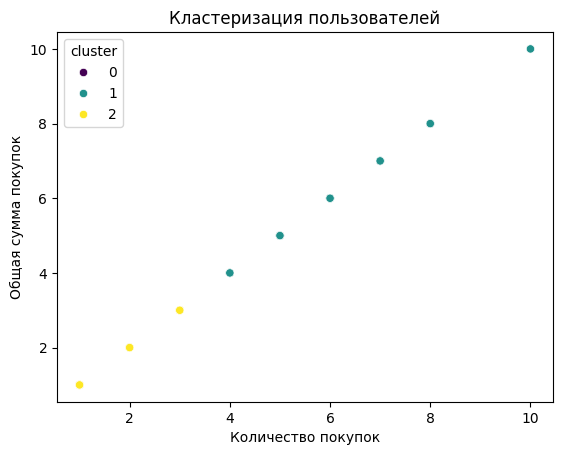

In [52]:
# Нормализация данных
scaler = StandardScaler()
user_data_scaled = scaler.fit_transform(user_data[['purchase_count', 'total_spent', 'days_since_last_purchase']])


# Применяем k-means для кластеризации
kmeans = KMeans(n_clusters=3, random_state=42)  # Выбираем 3 кластера
user_data['cluster'] = kmeans.fit_predict(user_data_scaled)

# Визуализация кластеров
sns.scatterplot(x=user_data['purchase_count'], y=user_data['total_spent'], hue=user_data['cluster'], palette='viridis')
plt.title('Кластеризация пользователей')
plt.xlabel('Количество покупок')
plt.ylabel('Общая сумма покупок')
plt.show()

Для 3 кластеров

In [53]:
# Анализ кластеров
cluster_summary = user_data.groupby('cluster').agg({
    'purchase_count': ['mean', 'min', 'max'],
    'total_spent': ['mean', 'min', 'max'],
    'days_since_last_purchase': ['mean', 'min', 'max']
}).reset_index()

print(cluster_summary)


  cluster purchase_count         total_spent         days_since_last_purchase  \
                    mean min max        mean min max                     mean   
0       0       1.119391   1   3    1.119391   1   3                36.187098   
1       1       5.319798   4  10    5.319798   4  10                 6.087578   
2       2       1.405570   1   3    1.405570   1   3                 9.849672   

           
  min max  
0  23  50  
1   0  36  
2   0  26  


In [54]:
# Присвоение названий сегментам
def assign_segment(row):
    if row['cluster'] == 0:
        return 'Одноразовые клиенты'
    elif row['cluster'] == 1:
        return 'Регулярные клиенты'
    else:
        return 'Лояльные клиенты'

user_data['segment'] = user_data.apply(assign_segment, axis=1)

# Итоговый датафрейм с сегментами
print(user_data[['user_id', 'purchase_count', 'total_spent', 'days_since_last_purchase', 'segment']])

       user_id  purchase_count  total_spent  days_since_last_purchase  \
0          404               2            2                        10   
1         5337               1            1                         3   
2         9010               4            4                         3   
3        19880               1            1                        21   
4        23403               4            4                         9   
...        ...             ...          ...                       ...   
62904  9694642               1            1                         0   
62905  9694662               1            1                         0   
62906  9694699               1            1                         0   
62907  9694734               1            1                         0   
62908  9694775               1            1                         0   

                  segment  
0        Лояльные клиенты  
1        Лояльные клиенты  
2      Регулярные клиенты  
3        Ло

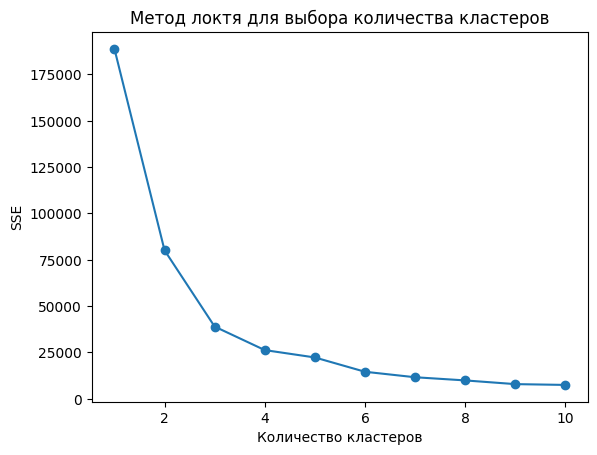

In [55]:
# Импорт библиотек
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Рассчитываем SSE для разного количества кластеров
sse = []
k_range = range(1, 11)  # Проверяем от 1 до 10 кластеров
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(user_data_scaled)
    sse.append(kmeans.inertia_)  # SSE (inertia) — сумма квадратов ошибок

# Строим график локтя
plt.plot(k_range, sse, marker='o')
plt.xlabel('Количество кластеров')
plt.ylabel('SSE')
plt.title('Метод локтя для выбора количества кластеров')
plt.show()

Внимание!

данный код работает 14 минут примерно.

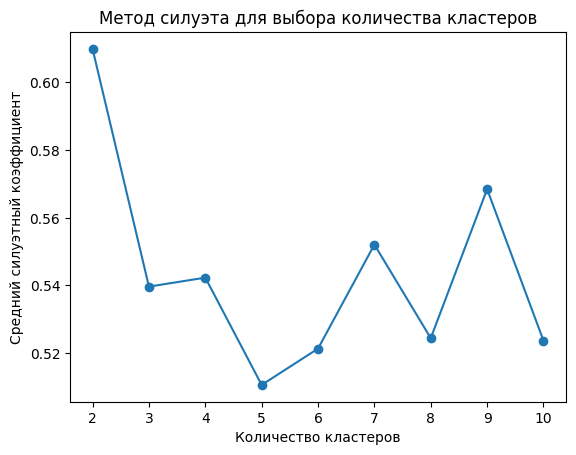

Количество кластеров: 2
  Кластер 0: Средний силуэтный коэффициент = 0.6326
  Кластер 1: Средний силуэтный коэффициент = 0.5052
  Средний силуэтный коэффициент для всех кластеров: 0.6099

Количество кластеров: 3
  Кластер 0: Средний силуэтный коэффициент = 0.5881
  Кластер 1: Средний силуэтный коэффициент = 0.5997
  Кластер 2: Средний силуэтный коэффициент = 0.4860
  Средний силуэтный коэффициент для всех кластеров: 0.5396

Количество кластеров: 4
  Кластер 0: Средний силуэтный коэффициент = 0.5753
  Кластер 1: Средний силуэтный коэффициент = 0.6428
  Кластер 2: Средний силуэтный коэффициент = 0.2409
  Кластер 3: Средний силуэтный коэффициент = 0.6446
  Средний силуэтный коэффициент для всех кластеров: 0.5423

Количество кластеров: 5
  Кластер 0: Средний силуэтный коэффициент = 0.5599
  Кластер 1: Средний силуэтный коэффициент = 0.4316
  Кластер 2: Средний силуэтный коэффициент = 0.3653
  Кластер 3: Средний силуэтный коэффициент = 0.6934
  Кластер 4: Средний силуэтный коэффициент = 0.4

In [57]:
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.pyplot as plt
import numpy as np

# Рассчитываем силуэтный коэффициент для разного количества кластеров
silhouette_avg_scores = []  # Средние значения силуэтного коэффициента
cluster_silhouette_scores = {}  # Значения силуэтного коэффициента для каждого кластера

k_range = range(2, 11)  # Силуэтный коэффициент нельзя рассчитать для 1 кластера
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    cluster_labels = kmeans.fit_predict(user_data_scaled)

    # Средний силуэтный коэффициент для всех кластеров
    silhouette_avg = silhouette_score(user_data_scaled, cluster_labels)
    silhouette_avg_scores.append(silhouette_avg)

    # Значения силуэтного коэффициента для каждого кластера
    sample_silhouette_values = silhouette_samples(user_data_scaled, cluster_labels)
    cluster_silhouette_scores[k] = {}

    for i in range(k):
        # Собираем значения силуэтного коэффициента для текущего кластера
        cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]
        cluster_silhouette_scores[k][i] = np.mean(cluster_silhouette_values)

# Строим график среднего силуэтного коэффициента
plt.plot(k_range, silhouette_avg_scores, marker='o')
plt.xlabel('Количество кластеров')
plt.ylabel('Средний силуэтный коэффициент')
plt.title('Метод силуэта для выбора количества кластеров')
plt.show()

# Выводим значения силуэтного коэффициента для каждого кластера
for k in k_range:
    print(f"Количество кластеров: {k}")
    for i in range(k):
        print(f"  Кластер {i}: Средний силуэтный коэффициент = {cluster_silhouette_scores[k][i]:.4f}")
    print(f"  Средний силуэтный коэффициент для всех кластеров: {silhouette_avg_scores[k-2]:.4f}\n")

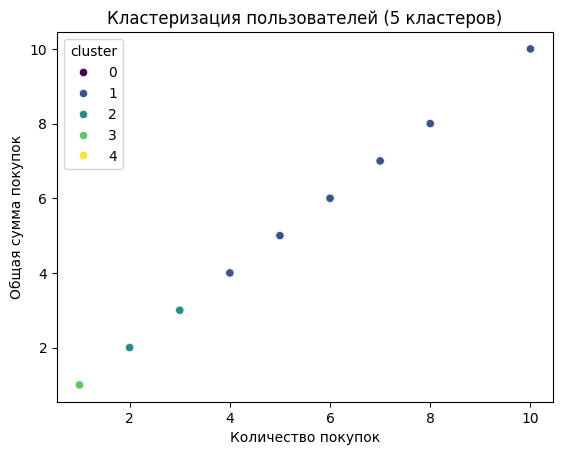

  cluster purchase_count         total_spent         days_since_last_purchase  \
                    mean min max        mean min max                     mean   
0       0       1.075879   1   3    1.075879   1   3                40.665584   
1       1       5.320115   4  10    5.320115   4  10                 6.080870   
2       2       2.454245   2   4    2.454245   2   4                 8.578503   
3       3       1.000000   1   1    1.000000   1   1                 6.751424   
4       4       1.092266   1   2    1.092266   1   2                23.002959   

           
  min max  
0  32  50  
1   0  29  
2   0  36  
3   0  14  
4  15  31  
       user_id  purchase_count  total_spent  days_since_last_purchase  \
0          404               2            2                        10   
1         5337               1            1                         3   
2         9010               4            4                         3   
3        19880               1            1             

In [58]:
# Применяем k-means для кластеризации (5 кластеров)
kmeans = KMeans(n_clusters=5, random_state=42)
user_data['cluster'] = kmeans.fit_predict(user_data_scaled)

# Визуализация кластеров
sns.scatterplot(x=user_data['purchase_count'], y=user_data['total_spent'], hue=user_data['cluster'], palette='viridis')
plt.title('Кластеризация пользователей (5 кластеров)')
plt.xlabel('Количество покупок')
plt.ylabel('Общая сумма покупок')
plt.show()

# Анализ кластеров
cluster_summary = user_data.groupby('cluster').agg({
    'purchase_count': ['mean', 'min', 'max'],
    'total_spent': ['mean', 'min', 'max'],
    'days_since_last_purchase': ['mean', 'min', 'max']
}).reset_index()

print(cluster_summary)

# Присвоение названий сегментам
def assign_segment(row):
    if row['cluster'] == 0:
        return 'Одноразовые клиенты'
    elif row['cluster'] == 1:
        return 'Редкие клиенты'
    elif row['cluster'] == 2:
        return 'Регулярные клиенты'
    elif row['cluster'] == 3:
        return 'Активные клиенты'
    else:
        return 'Лояльные клиенты'

user_data['segment'] = user_data.apply(assign_segment, axis=1)

# Итоговый датафрейм с сегментами
print(user_data[['user_id', 'purchase_count', 'total_spent', 'days_since_last_purchase', 'segment']])

Убедимся, что user_data_scaled имеет ту же количество строк, что и user_data, и то же количество столбцов, что и выбранные признаки

In [59]:
print(user_data_scaled.shape)  # Должно быть (n_samples, n_features)

(62909, 3)


Убедимся, что данные нормализованы (среднее = 0, стандартное отклонение = 1).

In [59]:
print(user_data_scaled.mean(axis=0))  # Должно быть близко к [0, 0, 0]
print(user_data_scaled.std(axis=0))   # Должно быть близко к [1, 1, 1]

[1.44573066e-17 1.44573066e-17 1.44573066e-17]
[1. 1. 1.]


Предыдущие данные показали, что оптимальное количество кластеров 2, это подтверждает и метод силуэта. Поэтому мы сделаем два класса.

'Редкие/одноразовые клиенты'

'Лояльные клиенты')

In [72]:
from sklearn.cluster import KMeans
import pandas as pd

# Выполняем кластеризацию (например, для 2 кластеров)
kmeans = KMeans(n_clusters=2, random_state=42)
user_data['cluster'] = kmeans.fit_predict(user_data_scaled)

# Добавляем сегменты
user_data['segment'] = user_data['cluster'].apply(lambda x: 'Редкие/одноразовые клиенты' if x == 0 else 'Лояльные клиенты')

# Выводим итоговый датафрейм
print(user_data[['user_id', 'purchase_count', 'total_spent', 'days_since_last_purchase', 'segment']].head())

   user_id  purchase_count  total_spent  days_since_last_purchase  \
0      404               2            2                        10   
1     5337               1            1                         3   
2     9010               4            4                         3   
3    19880               1            1                        21   
4    23403               4            4                         9   

                      segment  
0  Редкие/одноразовые клиенты  
1  Редкие/одноразовые клиенты  
2            Лояльные клиенты  
3  Редкие/одноразовые клиенты  
4            Лояльные клиенты  


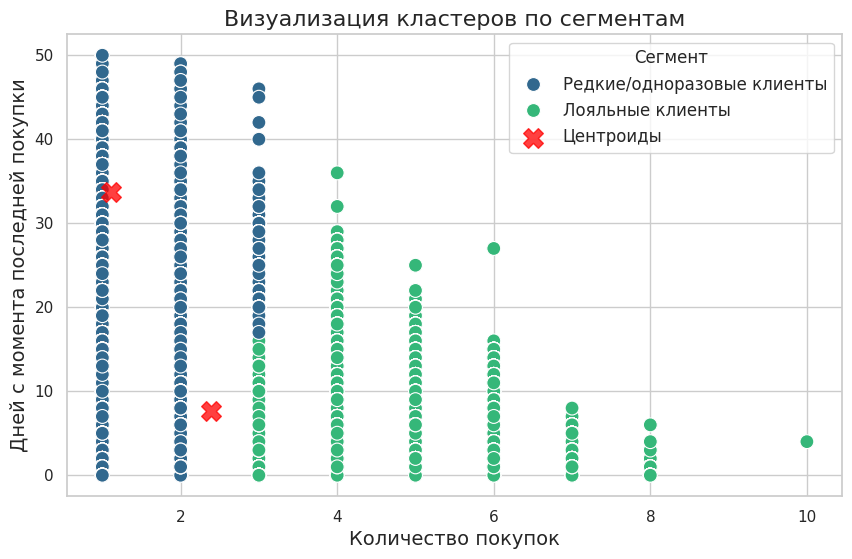

In [68]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler

# Настройка стиля графиков
sns.set(style="whitegrid")

# Создаем график
plt.figure(figsize=(10, 6))

# Точечный график для каждого сегмента
sns.scatterplot(
    x='purchase_count',  # Ось X: количество покупок
    y='days_since_last_purchase',  # Ось Y: дни с момента последней покупки
    hue='segment',  # Цвет точек по сегментам
    data=user_data,  # Данные
    palette='viridis',  # Цветовая палитра
    s=100  # Размер точек
)

# Нормализуем только те признаки, которые используем для визуализации
scaler = StandardScaler()
user_data_scaled_vis = scaler.fit_transform(user_data[['purchase_count', 'days_since_last_purchase']])

# Выполняем кластеризацию на нормализованных данных
kmeans = KMeans(n_clusters=2, random_state=42)
user_data['cluster'] = kmeans.fit_predict(user_data_scaled_vis)

# Денормализация центроидов
centers = scaler.inverse_transform(kmeans.cluster_centers_)  # Преобразование центроидов в исходное пространство

# Добавляем центроиды на график
plt.scatter(
    centers[:, 0],  # Ось X: purchase_count
    centers[:, 1],  # Ось Y: days_since_last_purchase
    c='red',  # Цвет центроидов
    s=200,  # Размер центроидов
    alpha=0.75,  # Прозрачность
    marker='X',  # Форма маркера (крестик)
    label='Центроиды'  # Подпись для легенды
)

# Добавляем заголовок и подписи осей
plt.title('Визуализация кластеров по сегментам', fontsize=16)
plt.xlabel('Количество покупок', fontsize=14)
plt.ylabel('Дней с момента последней покупки', fontsize=14)

# Легенда
plt.legend(title='Сегмент', title_fontsize=12, fontsize=12)

# Показываем график
plt.show()